In [224]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import optuna

seed = 211
np.random.seed(seed)

<ipython-input-224-88461a3b10a8>:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [225]:
filepath = 'input/NASDAQ_DAYLY.csv'
#d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%d')
nasdaq = pd.read_csv(filepath)
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d')
#data = data.sort_values('Date')
nasdaq = nasdaq.set_index('Date')
#nasdaq = nasdaq.sort_values(by='Date',ascending=False)
nasdaq = nasdaq[['Close']]
nasdaq

,Close
Date,
2002-12-18,1013.669983
2002-12-19,1006.049988
2002-12-20,1013.900024
2002-12-23,1032.300049
2002-12-24,1023.289978
...,...
2021-06-07,13802.889648
2021-06-08,13810.860352
2021-06-09,13814.940430


In [226]:
filepath = 'input/WALCL.csv'
#d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%d')
assets = pd.read_csv(filepath)
assets['DATE'] = pd.to_datetime(assets['DATE'], format = '%Y-%m-%d')
#data = data.sort_values('Date')
assets = assets.rename(columns={'DATE':'Date',"WALCL":'Millions_of_Dollars'})
assets.set_index('Date',inplace=True)
#assets.sort_values(by='DATE',ascending=False,inplace=True)
#(assets.index[1]-assets.index[0]).days
#assets.iloc[0]
assets

,Millions_of_Dollars
Date,
2002-12-18,719542.0
2002-12-25,732059.0
2003-01-01,730994.0
2003-01-08,723762.0
2003-01-15,720074.0
...,...
2021-05-12,7830663.0
2021-05-19,7922883.0
2021-05-26,7903541.0


In [227]:
#nasdaq = nasdaq.iloc[:assets.size]
nasdaq['Assets'] = assets['Millions_of_Dollars']
nasdaq = nasdaq.dropna()
nasdaq

,Close,Assets
Date,,
2002-12-18,1013.669983,719542.0
2003-01-08,1042.520020,723762.0
2003-01-15,1073.599976,720074.0
2003-01-22,1006.510010,735953.0
2003-01-29,1016.559998,712809.0
...,...,...
2021-05-12,13001.629883,7830663.0
2021-05-19,13237.910156,7922883.0
2021-05-26,13702.740234,7903541.0


In [228]:
scaler1 = MinMaxScaler(feature_range=(0.1, 1))
scaler2 = MinMaxScaler(feature_range=(0.1, 1))
scaled = nasdaq.copy()
scaled ['Close'] = scaler1.fit_transform(scaled['Close'].values.reshape(-1,1))
scaled ['Assets'] = scaler2.fit_transform(scaled['Assets'].values.reshape(-1,1))
scaled

,Close,Assets
Date,,
2002-12-18,0.103946,0.100837
2003-01-08,0.105946,0.101362
2003-01-15,0.108102,0.100903
2003-01-22,0.103449,0.102877
2003-01-29,0.104146,0.100000
...,...,...
2021-05-12,0.935264,0.984875
2021-05-19,0.951649,0.996340
2021-05-26,0.983883,0.993935


In [229]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back, use_perm = True):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back + 1): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    rand_perm = np.random.permutation(data.shape[0])
    if use_perm: 
        data = data[rand_perm,:,:]
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    y_train = y_train[:,0].reshape(-1,1)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    y_test = y_test[:,0].reshape(-1,1)
    
    return [x_train, y_train, x_test, y_test], rand_perm
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, 50, use_perm=False)
print(scaler1.inverse_transform(y_test)[-5:])

[[13001.629883]
 [13237.910156]
 [13702.740234]
 [13675.790039]
 [13814.94043 ]]


In [230]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

# Prediction with GRU

In [231]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def objective(trial):
    look_back = trial.suggest_int("Look Back",5,100) # choose sequence length
    [x_train, y_train, x_test, y_test], _ = load_data(scaled, look_back, use_perm=True)
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    input_dim = 2
    hidden_dim = trial.suggest_int("Hidden Dim",16,128,log=True)
    num_layers = trial.suggest_int("N layers",1,5)
    output_dim = 1
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

    loss_fn = torch.nn.MSELoss()
    lr = trial.suggest_float("Learning Rate",1e-4,1,log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    num_epochs = 1000
    factor = trial.suggest_float('Factor',0.1,1,log=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step(loss)
        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss

In [232]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study_gru = optuna.create_study(study_name="GRU", direction="minimize", sampler=sampler)
study_gru.optimize(objective, n_trials=100, timeout=120*60)

pruned_trials = [t for t in study_gru.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_gru.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study_gru.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

[I 2021-06-21 16:44:06,850] A new study created in memory with name: GRU
[I 2021-06-21 16:44:28,109] Trial 0 finished with value: 0.00013266385940369219 and parameters: {'Look Back': 56, 'Hidden Dim': 48, 'N layers': 2, 'Learning Rate': 0.0004921355367969423, 'Factor': 0.10312801359010905}. Best is trial 0 with value: 0.00013266385940369219.
[I 2021-06-21 16:44:37,493] Trial 1 finished with value: 8.172242814907804e-05 and parameters: {'Look Back': 46, 'Hidden Dim': 17, 'N layers': 2, 'Learning Rate': 0.011322743595157345, 'Factor': 0.5167094397872432}. Best is trial 1 with value: 8.172242814907804e-05.
[I 2021-06-21 16:44:41,764] Trial 2 finished with value: 0.00017638354620430619 and parameters: {'Look Back': 23, 'Hidden Dim': 19, 'N layers': 1, 'Learning Rate': 0.00026762425071296026, 'Factor': 0.2535675092643443}. Best is trial 1 with value: 8.172242814907804e-05.
[I 2021-06-21 16:45:12,808] Trial 3 finished with value: 0.00040984610677696764 and parameters: {'Look Back': 50, 'Hidd

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  92
  Number of complete trials:  8


In [233]:
optuna.visualization.plot_param_importances(study_gru)

In [234]:
print("Best trial:")
trial_gru = study_gru.best_trial

print("Value: ", trial_gru.value)
print(trial_gru.params)

Best trial:
Value:  7.031285349512473e-05
{'Look Back': 63, 'Hidden Dim': 23, 'N layers': 3, 'Learning Rate': 0.00638800406818388, 'Factor': 0.9948387771830486}


In [235]:
look_back = trial_gru.params['Look Back'] # choose sequence length
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm=True)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
#print(device)
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

x_train.shape =  (714, 62, 2)
y_train.shape =  (714, 1)
x_test.shape =  (179, 62, 2)
y_test.shape =  (179, 1)


In [236]:
input_dim = 2
hidden_dim = trial_gru.params['Hidden Dim']
num_layers = trial_gru.params['N layers']
output_dim = 1
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()
lr = trial_gru.params['Learning Rate']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
"""
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
print(list(model.parameters())[i].size())
"""
num_epochs = 1000
factor = trial_gru.params['Factor']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = 5)
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if epoch % 50 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    scheduler.step(loss)

Epoch  0 MSE:  0.3418048620223999
Epoch  50 MSE:  0.0017196277622133493
Epoch  100 MSE:  0.00015891897783149034
Epoch  150 MSE:  0.00012064241309417412
Epoch  200 MSE:  0.00011343316873535514
Epoch  250 MSE:  0.00010807505896082148
Epoch  300 MSE:  0.00010324386676074937
Epoch  350 MSE:  9.816706005949527e-05
Epoch  400 MSE:  9.456122643314302e-05
Epoch  450 MSE:  9.212196164298803e-05
Epoch  500 MSE:  9.018297714646906e-05
Epoch  550 MSE:  8.855002670316026e-05
Epoch  600 MSE:  8.711637201486155e-05
Epoch  650 MSE:  8.582830923842266e-05
Epoch  700 MSE:  8.473497291561216e-05
Epoch  750 MSE:  8.381614316022024e-05
Epoch  800 MSE:  8.302280184580013e-05
Epoch  850 MSE:  8.22955698822625e-05
Epoch  900 MSE:  8.154186798492447e-05
Epoch  950 MSE:  8.099461410893127e-05


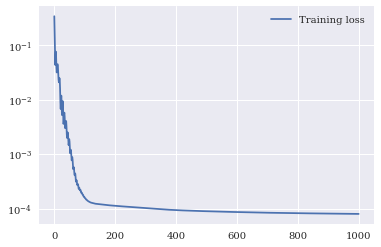

In [237]:
plt.semilogy(hist, label="Training loss")
plt.legend()
plt.show()

In [238]:
# make predictions
y_test_pred = model(x_test)
# invert predictions

y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler1.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())


In [239]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
#ShiftedtestScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
#print('Shifted Test Score: %.2f RMSE' % (ShiftedtestScore))

Train Score: 129.43 RMSE
Test Score: 132.76 RMSE


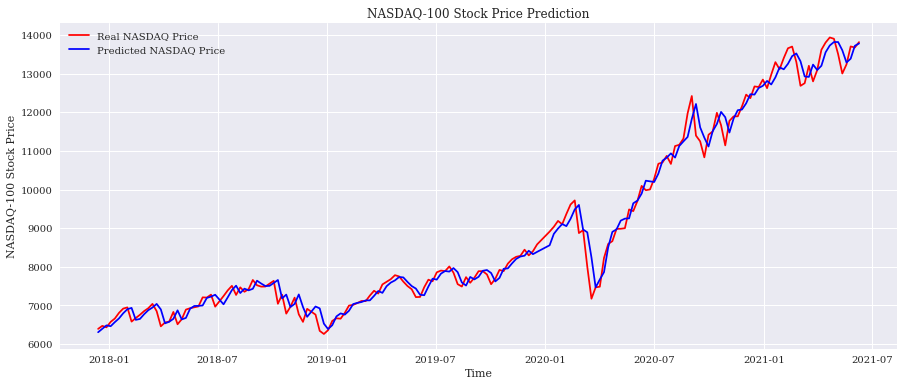

In [240]:
[_, _, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm = False)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
#y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_test_pred = model(x_test)
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test)
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('NASDAQ-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ-100 Stock Price')
plt.legend()

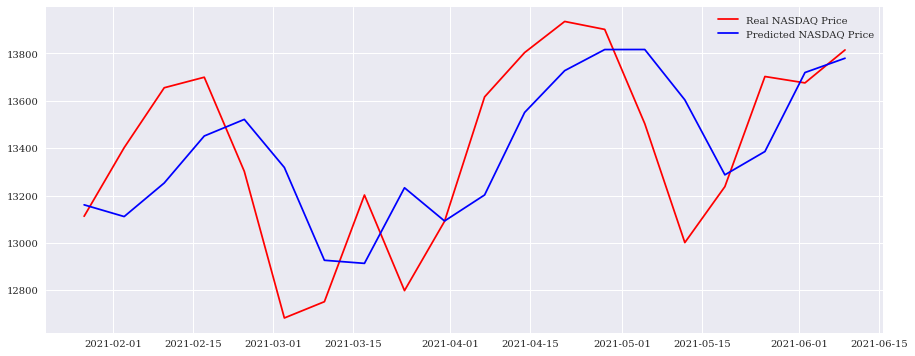

In [241]:
last = 20
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, y_test[-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, y_test_pred[-last:], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

[13839.82421875, 13877.2861328125, 13910.1767578125, 13944.6962890625, 13979.7705078125]


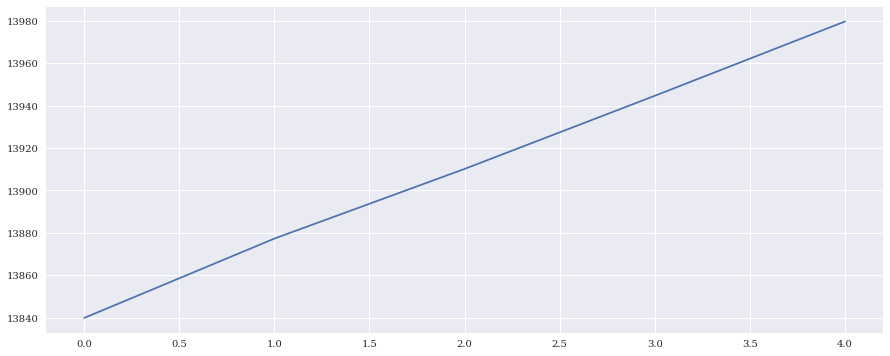

In [242]:
data_raw = scaled.values
predictions = []
n = 5
data = np.array(data_raw[len(data_raw) - look_back:])
x_test = data.reshape(1,data.shape[0],data.shape[1])
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
for _ in range(n):
    y_test_pred = model(x_test)
    tmp = torch.tensor([[[y_test_pred[0,0].item(),2*x_test[0,-1,1].item()-x_test[0,-2,1].item()]]]).to(device)
    #x_test = np.concatenate((data_raw,tmp),axis=0,dtype='object')
    x_test = torch.cat((x_test,tmp),1)[:,1:,:]
    ##print(x_test.shape)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    predictions.append(y_test_pred.item())
#print(predictions)
figure, axes = plt.subplots(figsize=(15, 6))
print(predictions)
axes.plot(predictions)
#next_week_forecast = model(data)

# Prediction with LSTM

In [243]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def objective(trial):
    look_back = trial.suggest_int("Look Back",5,100) # choose sequence length
    [x_train, y_train, x_test, y_test], _ = load_data(scaled, look_back, use_perm=True)
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    input_dim = 2
    hidden_dim = trial.suggest_int("Hidden Dim",16,128,log=True)
    num_layers = trial.suggest_int("N layers",1,3)
    output_dim = 1
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

    loss_fn = torch.nn.MSELoss()
    lr = trial.suggest_float("Learning Rate",1e-4,1,log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    num_epochs = 1000
    factor = trial.suggest_float('Factor',0.1,1,log=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step(loss)
        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss

In [244]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study_lstm = optuna.create_study(study_name="LSTM", direction="minimize", sampler=sampler)
study_lstm.optimize(objective, n_trials=100, timeout=120*60)

pruned_trials = [t for t in study_lstm.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_lstm.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study_lstm.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

[I 2021-06-21 16:47:42,614] A new study created in memory with name: LSTM
[I 2021-06-21 16:48:18,789] Trial 0 finished with value: 0.00017983111320063472 and parameters: {'Look Back': 56, 'Hidden Dim': 67, 'N layers': 2, 'Learning Rate': 0.002798315415368764, 'Factor': 0.34369102174888244}. Best is trial 0 with value: 0.00017983111320063472.
[I 2021-06-21 16:50:11,736] Trial 1 finished with value: 0.0003900669398717582 and parameters: {'Look Back': 60, 'Hidden Dim': 120, 'N layers': 3, 'Learning Rate': 0.0003675195986373514, 'Factor': 0.2058845966490188}. Best is trial 0 with value: 0.00017983111320063472.
[I 2021-06-21 16:50:27,738] Trial 2 finished with value: 0.00020600069547072053 and parameters: {'Look Back': 43, 'Hidden Dim': 82, 'N layers': 1, 'Learning Rate': 0.001851445569077532, 'Factor': 0.1793771794026209}. Best is trial 0 with value: 0.00017983111320063472.
[I 2021-06-21 16:50:43,308] Trial 3 finished with value: 0.00011932172492379323 and parameters: {'Look Back': 98, 'Hi

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  91
  Number of complete trials:  9


In [245]:
optuna.visualization.plot_param_importances(study_lstm)

In [246]:
print("Best trial:")
trial_lstm = study_lstm.best_trial

print("Value: ", trial_lstm.value)
print(trial_lstm.params)

Best trial:
Value:  8.040379907470196e-05
{'Look Back': 81, 'Hidden Dim': 17, 'N layers': 2, 'Learning Rate': 0.025568137455839083, 'Factor': 0.9979023805315722}


In [247]:
look_back = trial_lstm.params['Look Back'] # choose sequence length
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm=True)
#print('x_train.shape = ',x_train.shape)
#print('y_train.shape = ',y_train.shape)
#print('x_test.shape = ',x_test.shape)
#print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
#print(device)
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [248]:
input_dim = 2
hidden_dim = trial_lstm.params['Hidden Dim']
num_layers = trial_lstm.params['N layers']
output_dim = 1
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()
lr = trial_lstm.params['Learning Rate']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
"""
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
print(list(model.parameters())[i].size())
"""
num_epochs = 1000
factor = trial_lstm.params['Factor']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = 5)
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if epoch % 50 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    scheduler.step(loss)

Epoch  0 MSE:  0.11442962288856506
Epoch  50 MSE:  0.0005245705833658576
Epoch  100 MSE:  0.0002732657885644585
Epoch  150 MSE:  0.00022950625861994922
Epoch  200 MSE:  0.00020539398246910423
Epoch  250 MSE:  0.00018837284005712718
Epoch  300 MSE:  0.0001730676303850487
Epoch  350 MSE:  0.00015937202260829508
Epoch  400 MSE:  0.0001475958270020783
Epoch  450 MSE:  0.00013773204409517348
Epoch  500 MSE:  0.000129528678371571
Epoch  550 MSE:  0.0001226113672601059
Epoch  600 MSE:  0.00011659598385449499
Epoch  650 MSE:  0.00011117892427137122
Epoch  700 MSE:  0.00010618184023769572
Epoch  750 MSE:  0.0001015463494695723
Epoch  800 MSE:  9.730656165629625e-05
Epoch  850 MSE:  0.0003238497884012759
Epoch  900 MSE:  0.00010409629612695426
Epoch  950 MSE:  9.536762081552297e-05


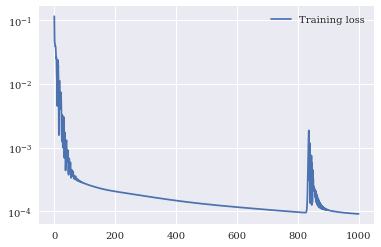

In [249]:
plt.semilogy(hist, label="Training loss")
plt.legend()
plt.show()

In [250]:
# make predictions
y_test_pred = model(x_test)
# invert predictions

y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler1.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())


In [251]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
#ShiftedtestScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
#print('Shifted Test Score: %.2f RMSE' % (ShiftedtestScore))

Train Score: 137.77 RMSE
Test Score: 133.83 RMSE


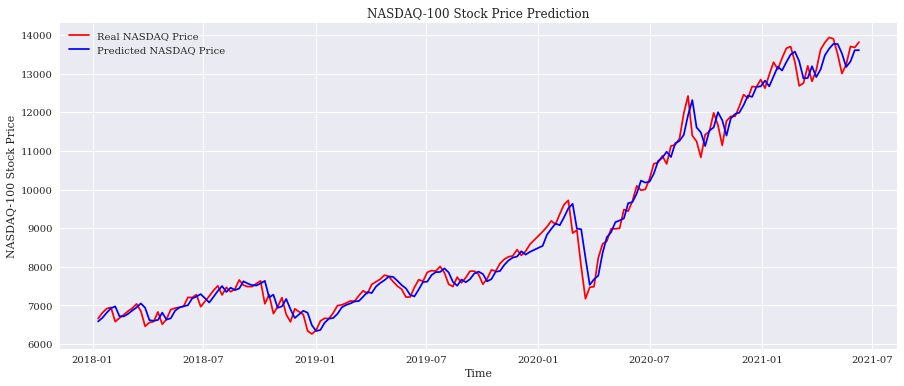

In [252]:
[_, _, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm = False)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
#y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_test_pred = model(x_test)
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test)
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('NASDAQ-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ-100 Stock Price')
plt.legend()

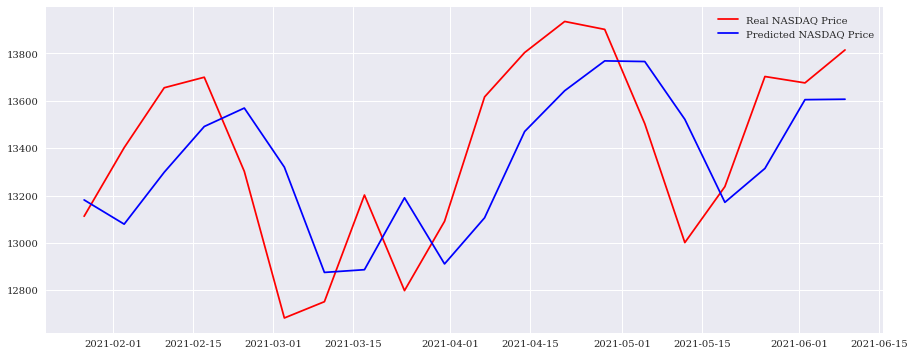

In [253]:
last = 20
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, y_test[-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, y_test_pred[-last:], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

[13720.3798828125, 13669.466796875, 13647.103515625, 13632.7685546875, 13623.478515625]


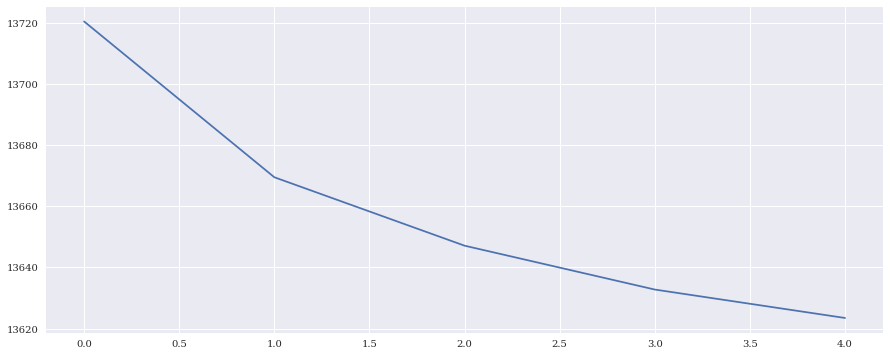

In [254]:
data_raw = scaled.values
predictions = []
n = 5
data = np.array(data_raw[len(data_raw) - look_back:])
x_test = data.reshape(1,data.shape[0],data.shape[1])
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
for _ in range(n):
    y_test_pred = model(x_test)
    tmp = torch.tensor([[[y_test_pred[0,0].item(),2*x_test[0,-1,1].item()-x_test[0,-2,1].item()]]]).to(device)
    #x_test = np.concatenate((data_raw,tmp),axis=0,dtype='object')
    x_test = torch.cat((x_test,tmp),1)[:,1:,:]
    ##print(x_test.shape)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    predictions.append(y_test_pred.item())
#print(predictions)
figure, axes = plt.subplots(figsize=(15, 6))
print(predictions)
axes.plot(predictions)
#next_week_forecast = model(data)

# Naive Predictor

In [257]:
dt = nasdaq.index[-1]-nasdaq.index[0]
dt = int(dt.days/7)
avg_weekly_gain = (nasdaq.iloc[-1,0]/nasdaq.iloc[0,0])**(1/dt)
#dt = len(nasdaq)
print(avg_weekly_gain)
dates = nasdaq.index
d0 = dates[0]
#naive = nasdaq.iloc[0,0]*avg_weekly_gain**((dates-d0).days/7)
naive = nasdaq['Close']*avg_weekly_gain
naiveScore = math.sqrt(mean_squared_error(naive[:-1], nasdaq['Close'][1:]))
print('Naive Predictor Score: %.2f RMSE' % (naiveScore))

1.0027133979117822
Naive Predictor Score: 131.50 RMSE


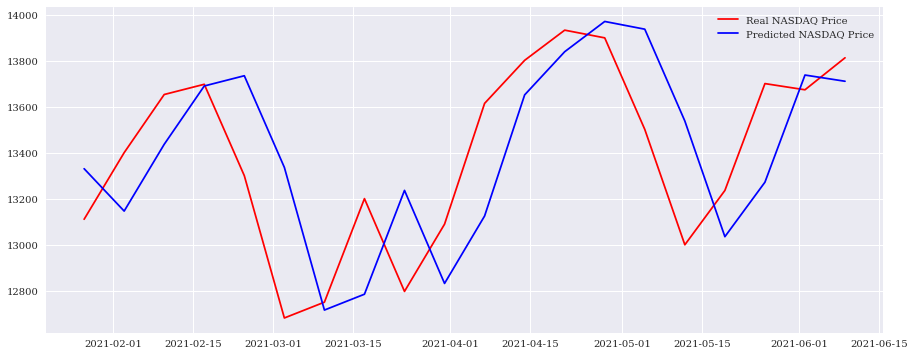

In [256]:
figure, axes = plt.subplots(figsize=(15, 6))
last = 20
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, nasdaq['Close'][-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, naive[-last-1:-1], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()